# Motivation

The idea is to analyze the tags provided on various problems that feature in programming contests to quantitatively see
which type of problems are most common at various rating divisions.

## Codeforces

For Codeforces, the common rating divisions are Div. 3, Div. 2 and Div. 1 with the problems ordered from least to most
difficult. It would make sense to first identify the most recent contests of these types, find the problems they contain,
and the corresponding tags. Then, we can visualize the distribution of the tags and see which are the most frequent,
along with possible secondary statistics like which tags are the "toughest" i.e., correspond to most failed attmepts,
which tags are the easiest and so on.

Relevant APIs are -
* `https://codeforces.com/api/contest.list`
* `https://codeforces.com/api/problemset.problems`

The first returns a list of all contests as a [`Contest`](https://codeforces.com/apiHelp/objects#Contest) object.

```json
{
    "id": 1854,
    "name": "Codeforces Round 889 (Div. 1)",
    "type": "CF",
    "phase": "BEFORE",
    "frozen": false,
    "durationSeconds": 9000,
    "startTimeSeconds": 1690641300,
    "relativeTimeSeconds": -147153
}
```

Relevant fields are only `id` and `name`. We need string-based heuristics for filtering the name to find the standard
Codeforces rounds and their intended "Div"s.

The problemset API returns a list of all problems as a [`Problem`]() object.

```json
{
    "contestId": 1853,
    "index": "B",
    "name": "Fibonaccharsis",
    "type": "PROGRAMMING",
    "points": 1000.0,
    "rating": 1200,
    "tags": ["binary search", "brute force", "math"]
}
```

Relevant fields are `contestId`, to tie back to the contest and check whether it came from a regular CF Round, and which
Div contest it came from. `rating` is also a useful feature to denote difficulty, and may be used skip the contest check
entirely. `tags` is obviously the one we want.

## Get data

In [3]:
import requests

import numpy as np
import polars as pl

### Contests

In [4]:
r = requests.get('https://codeforces.com/api/contest.list')
r.status_code

200

In [5]:
class Contest:
    def __init__(self, id: int, name: str, startTimeSeconds: int) -> None:
        self.id = id
        self.name = name
        self.startTimeSeconds = startTimeSeconds

    def __str__(self) -> str:
        return f'{self.id} {self.name} {self.startTimeSeconds}'

In [6]:
data = r.json()
contests_list = data['result']
print(contests_list[0])

{'id': 2034, 'name': 'Codeforces Round (Div. 1 + Div. 2)', 'type': 'CF', 'phase': 'BEFORE', 'frozen': False, 'durationSeconds': 7200, 'startTimeSeconds': 1732977300, 'relativeTimeSeconds': -1789582}


In [7]:
contests = [Contest(c['id'], c['name'], c['startTimeSeconds']) for c in contests_list]

ids = [c.id for c in contests]
names = [c.name for c in contests]
startTimes = [c.startTimeSeconds for c in contests]

df_contests = pl.DataFrame({
    'id': pl.Series(ids),
    'name': pl.Series(names),
    'startTimeSeconds': pl.Series(startTimes)
})
print(df_contests)

shape: (1_932, 3)
┌──────┬─────────────────────────────────┬──────────────────┐
│ id   ┆ name                            ┆ startTimeSeconds │
│ ---  ┆ ---                             ┆ ---              │
│ i64  ┆ str                             ┆ i64              │
╞══════╪═════════════════════════════════╪══════════════════╡
│ 2034 ┆ Codeforces Round (Div. 1 + Div… ┆ 1732977300       │
│ 2037 ┆ Codeforces Round (Div. 3)       ┆ 1731854100       │
│ 2031 ┆ Codeforces Round (Div. 2)       ┆ 1731674100       │
│ 2038 ┆ 2024-2025 ICPC, NERC, Southern… ┆ 1731580500       │
│ 2028 ┆ Codeforces Round 986 (Div. 2)   ┆ 1731252900       │
│ …    ┆ …                               ┆ …                │
│ 5    ┆ Codeforces Beta Round 5         ┆ 1269100800       │
│ 4    ┆ Codeforces Beta Round 4 (Div. … ┆ 1268395200       │
│ 3    ┆ Codeforces Beta Round 3         ┆ 1267963200       │
│ 2    ┆ Codeforces Beta Round 2         ┆ 1267117200       │
│ 1    ┆ Codeforces Beta Round 1         ┆ 126658080

Preprocess to add `Boolean` columns to describe whether the contest was Div.1, Div. 2, or Div. 3.

In [8]:
df_contests = df_contests.with_columns(
    is_div1=pl.col("name").str.contains("Div. 1"),
    is_div2=pl.col("name").str.contains("Div. 2"),
    is_div3=pl.col("name").str.contains("Div. 3"),
)
df_contests

id,name,startTimeSeconds,is_div1,is_div2,is_div3
i64,str,i64,bool,bool,bool
2034,"""Codeforces Round (Div. 1 + Div…",1732977300,true,true,false
2037,"""Codeforces Round (Div. 3)""",1731854100,false,false,true
2031,"""Codeforces Round (Div. 2)""",1731674100,false,true,false
2038,"""2024-2025 ICPC, NERC, Southern…",1731580500,false,false,false
2028,"""Codeforces Round 986 (Div. 2)""",1731252900,false,true,false
…,…,…,…,…,…
5,"""Codeforces Beta Round 5""",1269100800,false,false,false
4,"""Codeforces Beta Round 4 (Div. …",1268395200,false,true,false
3,"""Codeforces Beta Round 3""",1267963200,false,false,false


### Problems

In [9]:
r = requests.get('https://codeforces.com/api/problemset.problems')
r.status_code

200

In [10]:
from typing import List

class Problem:
    def __init__(self, name: str, rating: int, tags: List[str], contestId: int) -> None:
        self.name = name
        self.rating = rating
        self.tags = tags
        self.contestId = contestId
    
    def __repr__(self) -> str:
        return f'Problem(name={str(self.name)}, rating={str(self.rating)}, tags={str(self.tags)})'
    
    def __str__(self) -> str:
        return repr(self)

In [11]:
data = r.json()
problems = data['result']['problems']
print(problems[0])

{'contestId': 2036, 'index': 'G', 'name': 'Library of Magic', 'type': 'PROGRAMMING', 'tags': ['binary search', 'constructive algorithms', 'divide and conquer', 'interactive', 'math', 'number theory']}


In [12]:
problems = [Problem(problem['name'], problem.get('rating', np.nan), problem.get('tags', []), problem['contestId']) for problem in problems]
print(problems[0])

Problem(name=Library of Magic, rating=nan, tags=['binary search', 'constructive algorithms', 'divide and conquer', 'interactive', 'math', 'number theory'])


In [13]:
names = pl.Series([problem.name for problem in problems])
ratings = pl.Series([problem.rating for problem in problems], dtype=pl.Float32)
tags = [problem.tags for problem in problems]
contestIds = pl.Series([problem.contestId for problem in problems])

df_problems = pl.DataFrame({
    'name': names,
    'rating': ratings,
    'tags': tags,
    'contestId': contestIds
})
df_problems

name,rating,tags,contestId
str,f32,list[str],i64
"""Library of Magic""",NaN,"[""binary search"", ""constructive algorithms"", … ""number theory""]",2036
"""XORificator 3000""",NaN,"[""bitmasks"", ""dp"", … ""two pointers""]",2036
"""Reverse the Rivers""",NaN,"[""binary search"", ""constructive algorithms"", … ""greedy""]",2036
"""I Love 1543""",NaN,"[""brute force"", ""implementation"", ""matrices""]",2036
"""Anya and 1100""",NaN,"[""brute force"", ""implementation""]",2036
…,…,…,…
"""The least round way""",2000.0,"[""dp"", ""math""]",2
"""Winner""",1500.0,"[""hashing"", ""implementation""]",2
"""Ancient Berland Circus""",2100.0,"[""geometry"", ""math""]",1


Join both DataFrames to obtain a list of all problems along with the contest it is present in.

In [14]:
df = df_problems.join(df_contests, left_on="contestId", right_on="id", how='inner')
df

name,rating,tags,contestId,name_right,startTimeSeconds,is_div1,is_div2,is_div3
str,f32,list[str],i64,str,i64,bool,bool,bool
"""Library of Magic""",NaN,"[""binary search"", ""constructive algorithms"", … ""number theory""]",2036,"""Codeforces Round 984 (Div. 3)""",1730558100,false,false,true
"""XORificator 3000""",NaN,"[""bitmasks"", ""dp"", … ""two pointers""]",2036,"""Codeforces Round 984 (Div. 3)""",1730558100,false,false,true
"""Reverse the Rivers""",NaN,"[""binary search"", ""constructive algorithms"", … ""greedy""]",2036,"""Codeforces Round 984 (Div. 3)""",1730558100,false,false,true
"""I Love 1543""",NaN,"[""brute force"", ""implementation"", ""matrices""]",2036,"""Codeforces Round 984 (Div. 3)""",1730558100,false,false,true
"""Anya and 1100""",NaN,"[""brute force"", ""implementation""]",2036,"""Codeforces Round 984 (Div. 3)""",1730558100,false,false,true
…,…,…,…,…,…,…,…,…
"""The least round way""",2000.0,"[""dp"", ""math""]",2,"""Codeforces Beta Round 2""",1267117200,false,false,false
"""Winner""",1500.0,"[""hashing"", ""implementation""]",2,"""Codeforces Beta Round 2""",1267117200,false,false,false
"""Ancient Berland Circus""",2100.0,"[""geometry"", ""math""]",1,"""Codeforces Beta Round 1""",1266580800,false,false,false


### Preprocessing

In [15]:
all_tags = set(tag for tags_list in df['tags'] for tag in tags_list)
print(len(all_tags))
print(all_tags)

37
{'divide and conquer', 'games', 'two pointers', 'implementation', 'fft', 'brute force', 'math', 'trees', 'dfs and similar', 'probabilities', 'strings', 'expression parsing', 'dsu', 'flows', 'chinese remainder theorem', 'hashing', '2-sat', 'graphs', 'greedy', 'sortings', 'shortest paths', 'interactive', 'data structures', 'constructive algorithms', 'number theory', 'combinatorics', 'schedules', 'ternary search', 'string suffix structures', 'dp', 'bitmasks', '*special', 'meet-in-the-middle', 'binary search', 'geometry', 'matrices', 'graph matchings'}


In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
tags_transformer = mlb.fit(df['tags'])
tags_transformer.classes_

array(['*special', '2-sat', 'binary search', 'bitmasks', 'brute force',
       'chinese remainder theorem', 'combinatorics',
       'constructive algorithms', 'data structures', 'dfs and similar',
       'divide and conquer', 'dp', 'dsu', 'expression parsing', 'fft',
       'flows', 'games', 'geometry', 'graph matchings', 'graphs',
       'greedy', 'hashing', 'implementation', 'interactive', 'math',
       'matrices', 'meet-in-the-middle', 'number theory', 'probabilities',
       'schedules', 'shortest paths', 'sortings',
       'string suffix structures', 'strings', 'ternary search', 'trees',
       'two pointers'], dtype=object)

In [17]:
df_tags = pl.DataFrame(tags_transformer.transform(df['tags']), schema=[(tag, pl.Boolean) for tag in tags_transformer.classes_])
df_tags

*special,2-sat,binary search,bitmasks,brute force,chinese remainder theorem,combinatorics,constructive algorithms,data structures,dfs and similar,divide and conquer,dp,dsu,expression parsing,fft,flows,games,geometry,graph matchings,graphs,greedy,hashing,implementation,interactive,math,matrices,meet-in-the-middle,number theory,probabilities,schedules,shortest paths,sortings,string suffix structures,strings,ternary search,trees,two pointers
bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
false,false,true,false,false,false,false,true,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,true,true,false,false,true,false,false,false,false,false,false,false,false,false
false,false,false,true,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,true
false,false,true,false,false,false,false,true,true,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,true,false,false,false,false,false,false,false,false,false,false,false
false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false
false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false
false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false


In [18]:
df = pl.concat([df, df_tags], how='horizontal')
df

name,rating,tags,contestId,name_right,startTimeSeconds,is_div1,is_div2,is_div3,*special,2-sat,binary search,bitmasks,brute force,chinese remainder theorem,combinatorics,constructive algorithms,data structures,dfs and similar,divide and conquer,dp,dsu,expression parsing,fft,flows,games,geometry,graph matchings,graphs,greedy,hashing,implementation,interactive,math,matrices,meet-in-the-middle,number theory,probabilities,schedules,shortest paths,sortings,string suffix structures,strings,ternary search,trees,two pointers
str,f32,list[str],i64,str,i64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
"""Library of Magic""",NaN,"[""binary search"", ""constructive algorithms"", … ""number theory""]",2036,"""Codeforces Round 984 (Div. 3)""",1730558100,false,false,true,false,false,true,false,false,false,false,true,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,true,true,false,false,true,false,false,false,false,false,false,false,false,false
"""XORificator 3000""",NaN,"[""bitmasks"", ""dp"", … ""two pointers""]",2036,"""Codeforces Round 984 (Div. 3)""",1730558100,false,false,true,false,false,false,true,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,true
"""Reverse the Rivers""",NaN,"[""binary search"", ""constructive algorithms"", … ""greedy""]",2036,"""Codeforces Round 984 (Div. 3)""",1730558100,false,false,true,false,false,true,false,false,false,false,true,true,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
"""I Love 1543""",NaN,"[""brute force"", ""implementation"", ""matrices""]",2036,"""Codeforces Round 984 (Div. 3)""",1730558100,false,false,true,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,true,false,false,false,false,false,false,false,false,false,false,false
"""Anya and 1100""",NaN,"[""brute force"", ""implementation""]",2036,"""Codeforces Round 984 (Div. 3)""",1730558100,false,false,true,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""The least round way""",2000.0,"[""dp"", ""math""]",2,"""Codeforces Beta Round 2""",1267117200,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false
"""Winner""",1500.0,"[""hashing"", ""implementation""]",2,"""Codeforces Beta Round 2""",1267117200,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false
"""Ancient Berland Circus""",2100.0,"[""geometry"", ""math""]",1,"""Codeforces Beta Round 1""",1266580800,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false


### Visualization

Given this data, we want to gain insight into which tags are more common at certain rating ranges, such that competitors at those ranges have an idea of which problem tags will be useful to study if they want to progress.

In [21]:
tag_freqs = df.filter(pl.col("is_div1")).select(pl.col(all_tags)).sum()
tag_freqs

divide and conquer,games,two pointers,implementation,fft,brute force,math,trees,dfs and similar,probabilities,strings,expression parsing,dsu,flows,chinese remainder theorem,hashing,2-sat,graphs,greedy,sortings,shortest paths,interactive,data structures,constructive algorithms,number theory,combinatorics,schedules,ternary search,string suffix structures,dp,bitmasks,*special,meet-in-the-middle,binary search,geometry,matrices,graph matchings
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
102,69,123,368,43,313,632,283,256,91,133,8,106,41,7,60,12,319,568,197,78,57,532,439,178,212,4,12,28,607,144,0,11,232,121,44,31


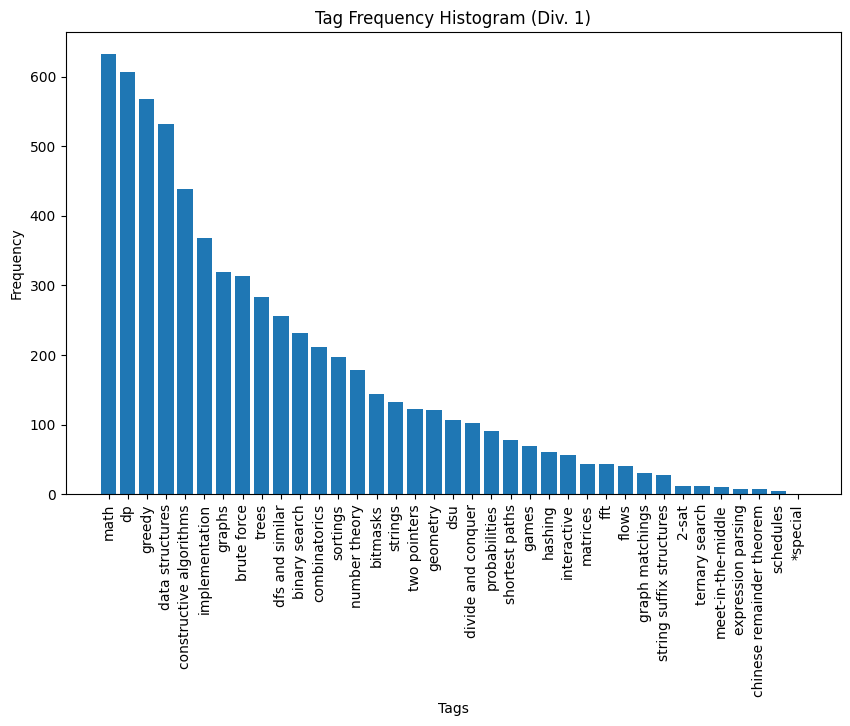

In [ ]:
import matplotlib.pyplot as plt

# Assuming df is your Polars DataFrame and all_tags is your list of tag column names
# Filter the DataFrame to include only the relevant tags
filtered_df = df.filter(pl.col('is_div1'))

# Sum the boolean columns to get the frequency of each tag
tag_frequencies = filtered_df.select(all_tags).sum().to_dict(as_series=False)

# Convert to a list of tuples and sort by frequency in ascending order
sorted_tag_frequencies = sorted(tag_frequencies.items(), key=lambda x: x[1], reverse=True)

# Unzip the sorted list into two lists: tags and frequencies
tags, frequencies = zip(*sorted_tag_frequencies)

# Convert frequencies from Polars Series to a list of numbers
frequencies = [freq[0] for freq in frequencies]

# Plot the sorted histogram
plt.figure(figsize=(10, 6))
plt.bar(tags, frequencies)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Tag Frequency Histogram (Div. 1)')
plt.xticks(rotation=90)
plt.show()

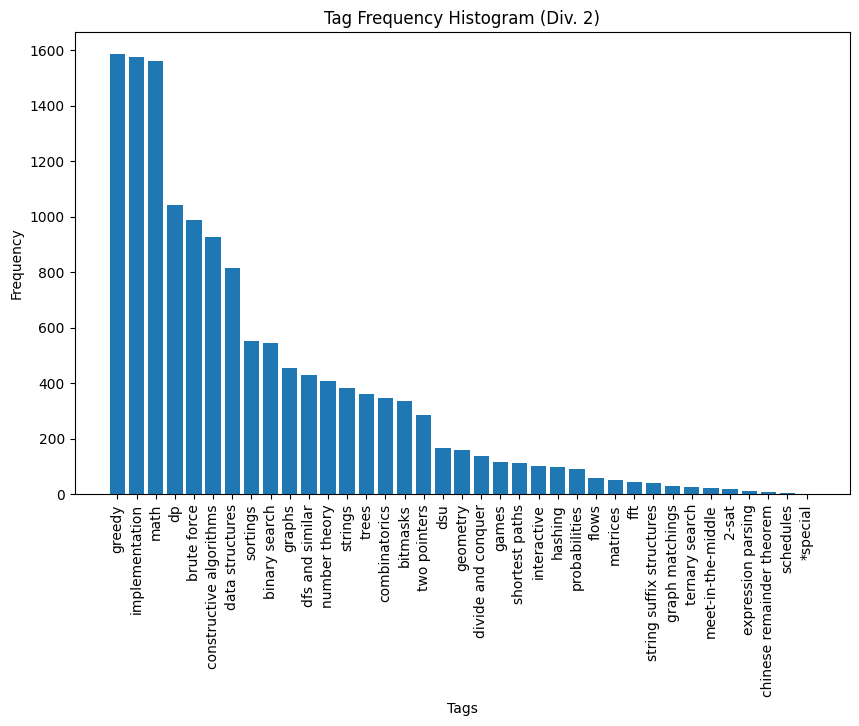

In [30]:
import matplotlib.pyplot as plt

# Assuming df is your Polars DataFrame and all_tags is your list of tag column names
# Filter the DataFrame to include only the relevant tags
filtered_df = df.filter(pl.col('is_div2'))

# Sum the boolean columns to get the frequency of each tag
tag_frequencies = filtered_df.select(all_tags).sum().to_dict(as_series=False)

# Convert to a list of tuples and sort by frequency in ascending order
sorted_tag_frequencies = sorted(tag_frequencies.items(), key=lambda x: x[1], reverse=True)

# Unzip the sorted list into two lists: tags and frequencies
tags, frequencies = zip(*sorted_tag_frequencies)

# Convert frequencies from Polars Series to a list of numbers
frequencies = [freq[0] for freq in frequencies]

# Plot the sorted histogram
plt.figure(figsize=(10, 6))
plt.bar(tags, frequencies)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Tag Frequency Histogram (Div. 2)')
plt.xticks(rotation=90)
plt.show()

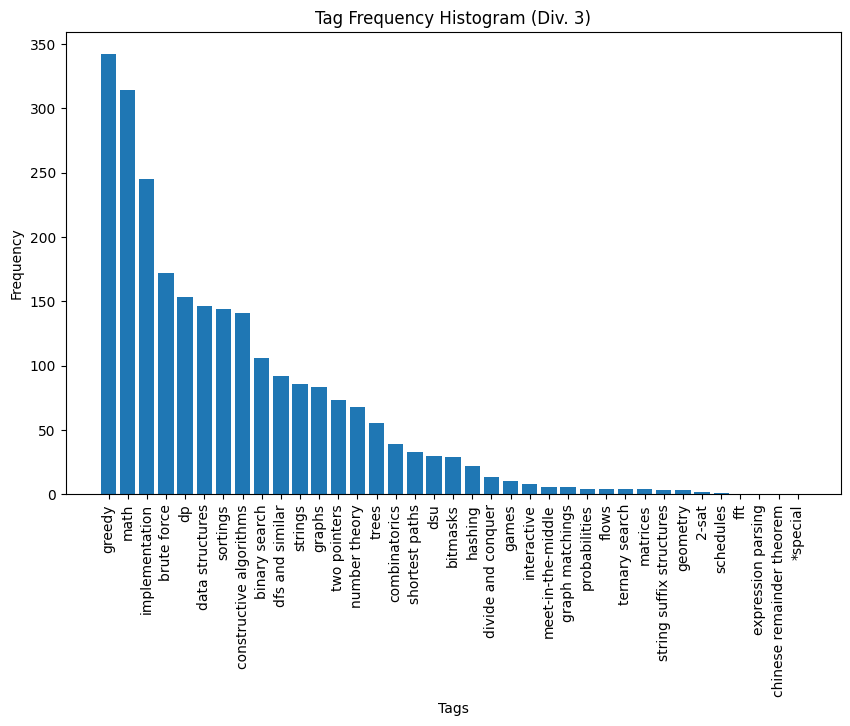

In [29]:
import matplotlib.pyplot as plt

# Assuming df is your Polars DataFrame and all_tags is your list of tag column names
# Filter the DataFrame to include only the relevant tags
filtered_df = df.filter(pl.col('is_div3'))

# Sum the boolean columns to get the frequency of each tag
tag_frequencies = filtered_df.select(all_tags).sum().to_dict(as_series=False)

# Convert to a list of tuples and sort by frequency in ascending order
sorted_tag_frequencies = sorted(tag_frequencies.items(), key=lambda x: x[1], reverse=True)

# Unzip the sorted list into two lists: tags and frequencies
tags, frequencies = zip(*sorted_tag_frequencies)

# Convert frequencies from Polars Series to a list of numbers
frequencies = [freq[0] for freq in frequencies]

# Plot the sorted histogram
plt.figure(figsize=(10, 6))
plt.bar(tags, frequencies)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Tag Frequency Histogram (Div. 3)')
plt.xticks(rotation=90)
plt.show()

## CodeChef

For CodeChef, we have two rating divisions of Div 2., and Div 1. There are long contests, short contests and Snacktime.
For each of these, we can repeat the same process as in Codeforces.